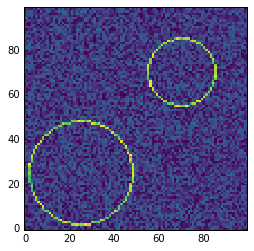

In [1]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2

from skimage.transform import hough_circle
from skimage.draw import circle_perimeter
img = np.zeros((100, 100), dtype=float)

rr1, cc1 = circle_perimeter(25, 25, 23)
img[rr1, cc1] = 1

rr2, cc2 = circle_perimeter(70, 70, 15)
img[rr2, cc2] = 1

#try_radii = np.arange(5, 50)
#res = hough_circle(img, try_radii)
#ridx, r, c = np.unravel_index(np.argmax(res), res.shape)
#r, c, try_radii[ridx]

img += 0.5*np.random.rand(100, 100)

kwargs = dict(origin='lower', interpolation='nearest',
              cmap=plt.cm.viridis)
plt.imshow(img, **kwargs)

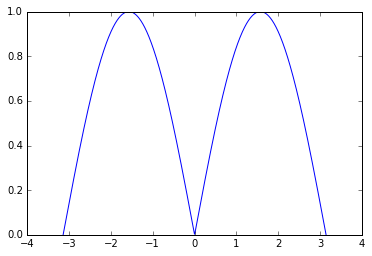

In [2]:
# Filter
k = 2 # filter index
N = 3 # number of filters
omega_k = np.pi * (k - 1)/(N - 1)
def F_k(omega, omega_k):
    result = np.zeros_like(omega)
    in_bounds_plus = (np.abs(omega + omega_k) <= np.pi/(N-1))
    in_bounds_minus = (np.abs(omega - omega_k) <= np.pi/(N-1))
    result[in_bounds_plus] = np.cos(omega[in_bounds_plus] + omega_k)
    result[in_bounds_minus] = np.cos(omega[in_bounds_minus] - omega_k)
    return result

omegas = np.linspace(-np.pi, np.pi, 1000)
plt.plot(omegas, F_k(omegas, omega_k))

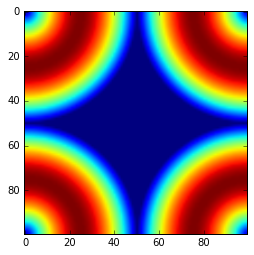

In [3]:
fft = fft2(img)
freqs = np.fft.fftfreq(fft.shape[0])
r_0 = 23
G_k = np.ones_like(fft, dtype=float)
freqs = np.fft.fftfreq(fft.shape[0])
w_1, w_2 = np.meshgrid(2*np.pi*freqs, 2*np.pi*freqs)
mag_w = np.sqrt(w_1**2 + w_2**2)
G_k = np.exp(-1j * mag_w * r_0) * F_k(mag_w, omega_k)

plt.imshow(np.abs(G_k))

In [4]:
circlets = ifft2(fft*G_k)

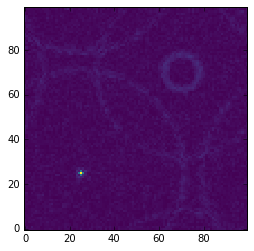

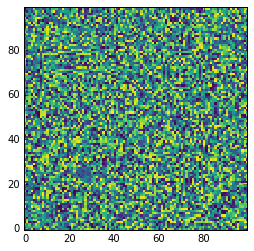

In [5]:
plt.imshow(np.abs(circlets), **kwargs)
plt.figure()
plt.imshow(np.arctan(circlets.imag / circlets.real), **kwargs)

# Functional form

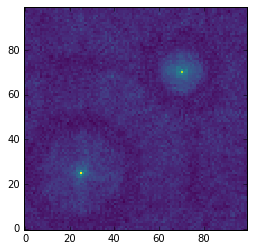

In [6]:
k = 2 # filter index
N = 3 # number of filters
omegas = np.linspace(-np.pi, np.pi, 1000)
omega_k = np.pi * (k - 1)/(N - 1)

def F_k(omega, omega_k):
    result = np.zeros_like(omega)
    in_bounds_plus = (np.abs(omega + omega_k) <= np.pi/(N-1))
    in_bounds_minus = (np.abs(omega - omega_k) <= np.pi/(N-1))
    result[in_bounds_plus] = np.cos(omega[in_bounds_plus] + omega_k)
    result[in_bounds_minus] = np.cos(omega[in_bounds_minus] - omega_k)
    return result

def G_k(omega, omega_k, fft, radius):
    G_k = np.ones_like(fft, dtype=float)
    freqs = np.fft.fftfreq(fft.shape[0])
    w_1, w_2 = np.meshgrid(2*np.pi*freqs, 2*np.pi*freqs)
    mag_w = np.sqrt(w_1**2 + w_2**2)
    return np.exp(-1j * mag_w * radius) * F_k(mag_w, omega_k)

def circlet_decompose(image, omega, omega_k, radius):
    fft = fft2(image)
    circlet_filter = G_k(omega, omega_k, fft, radius)
    circlet_coefficients = np.abs(ifft2(fft*circlet_filter))
    return circlet_coefficients

radius = 23
radii = np.arange(5, 25, 0.5)
power = np.zeros_like(img)
for r in radii:
    circlet_coefficients = circlet_decompose(img, omegas, omega_k, r)
    power += np.abs(circlet_coefficients)
plt.imshow(power, **kwargs)

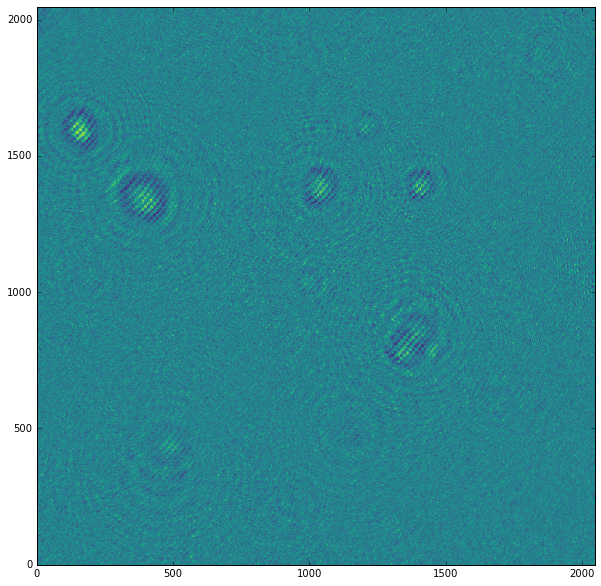

In [7]:
holo_cube = np.load('../shampoo/holo_cube.npy')
med = np.load('../shampoo/median.npy')

def plot(array, title=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(array, **kwargs)
    if title is not None:
        plt.title(title)
    plt.show()
h105 = holo_cube[104] - med
plot(h105)

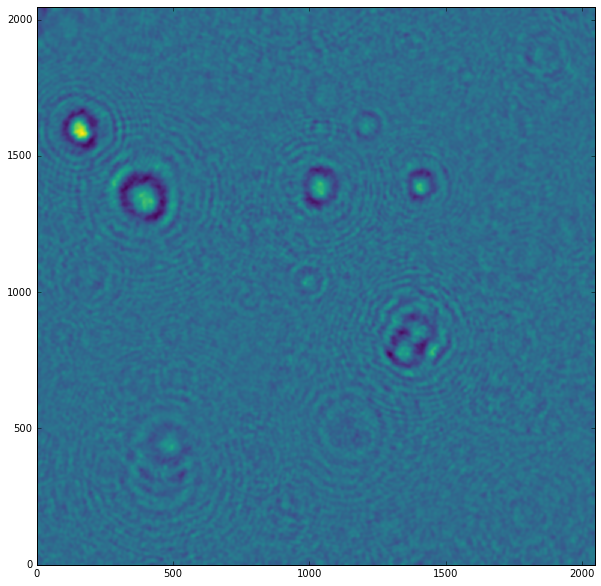

In [21]:
from scipy.ndimage import gaussian_filter
smooth_h105 = gaussian_filter(h105, 5)

plot(smooth_h105)

In [22]:
from multiprocessing.dummy import Pool as ThreadPool

class CircletTransform(object):
    """
    Circlet transform as defined by Chauris et al. 2011 [1]_
    
    .. [1] http://archimer.ifremer.fr/doc/00033/14451/11752.pdf
    """
    def __init__(self, image, k=2, N=3, threads=8):
        self.k = k
        self.N = N
        self.omegas = np.linspace(-np.pi, np.pi, image.shape[0])
        self.omega_k = np.pi * (self.k - 1)/(self.N - 1)
        self.fft_image = fft2(image)
        self._F_k = None
        
        freqs = np.fft.fftfreq(self.fft_image.shape[0])
        w_1, w_2 = np.meshgrid(2*np.pi*freqs, 2*np.pi*freqs)
        self.mag_w = np.sqrt(w_1**2 + w_2**2)
        self.threads = threads
        
    @property
    def F_k(self):
        # Cache this value
        if self._F_k is None:
            result = np.zeros_like(self.omegas)
            in_bounds_plus = (np.abs(self.omegas + self.omega_k) <= np.pi/(self.N-1))
            in_bounds_minus = (np.abs(self.omegas - self.omega_k) <= np.pi/(self.N-1))
            result[in_bounds_plus] = np.cos(self.omegas[in_bounds_plus] + self.omega_k)
            result[in_bounds_minus] = np.cos(self.omegas[in_bounds_minus] - self.omega_k)
            self._F_k = result
        return self._F_k

    def G_k(self, radius):
        # Chauris et al. 2011, Equation 7:
        return np.exp(-1j * self.mag_w * radius) * self.F_k

    def coefficients(self, radius):
        circlet_coefficients = ifft2(self.fft_image*self.G_k(radius))
        return circlet_coefficients
    
    def coefficients_multithread(self, radii):
        
        _ = self.F_k
        circlet_coefficients = np.zeros((len(radii), self.fft_image.shape[0], 
                                         self.fft_image.shape[1]))
        def job(i):
            circlet_coefficients[i, ...] = self.coefficients(radii[i])
        
        pool = ThreadPool(self.threads)
        pool.map(job, range(len(radii)))

        # close the pool and wait for the work to finish
        pool.close()
        pool.join()
        return circlet_coefficients

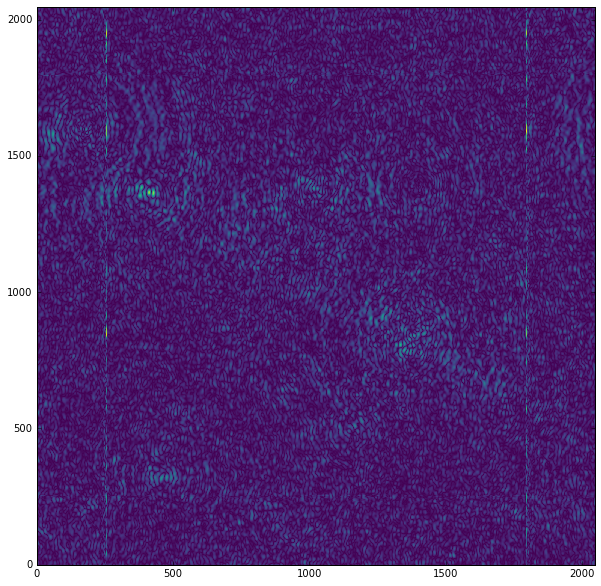

1.41586924446


In [31]:
p = np.abs(circlet_coefficients[50, ...])
plot(p)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


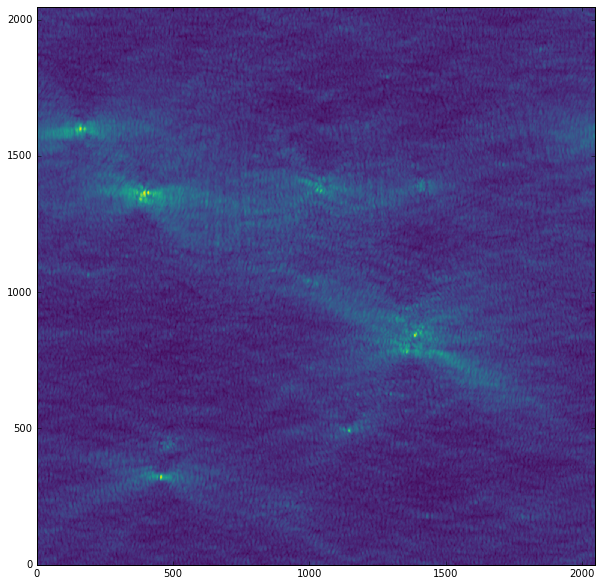

In [35]:
radii = np.arange(5, 500, 5)
power = np.zeros_like(smooth_h105)
c = CircletTransform(smooth_h105)
circlet_coefficients = c.coefficients_multithread(radii)
abs_coeffs = np.abs(circlet_coefficients)
coeffs_mean = np.mean(abs_coeffs, axis=(1, 2))[:, np.newaxis, np.newaxis]
coeffs_std = np.std(abs_coeffs, axis=(1, 2))[:, np.newaxis, np.newaxis]

power = np.sum((abs_coeffs - coeffs_mean)/coeffs_std, axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(power, **kwargs)

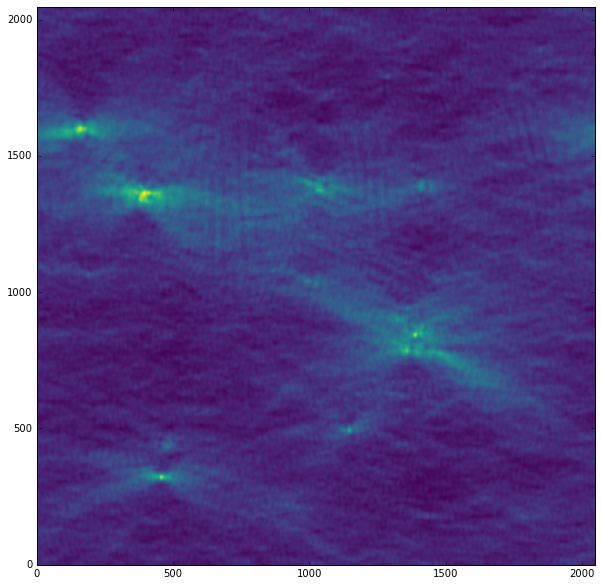

In [36]:
from scipy.ndimage import white_tophat

plot(gaussian_filter(power, 5))

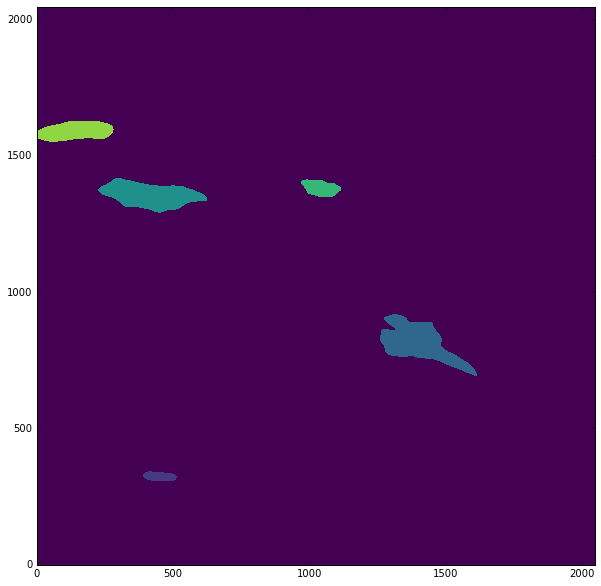

In [48]:
from skimage.filters import threshold_otsu, threshold_yen
from skimage.measure import label, regionprops

smooth_power = gaussian_filter(power, 15)

thresh = threshold_yen(smooth_power)

masked = np.ones_like(smooth_power)
masked[smooth_power <= thresh] = 0

label_image = label(masked)

plot(label_image)

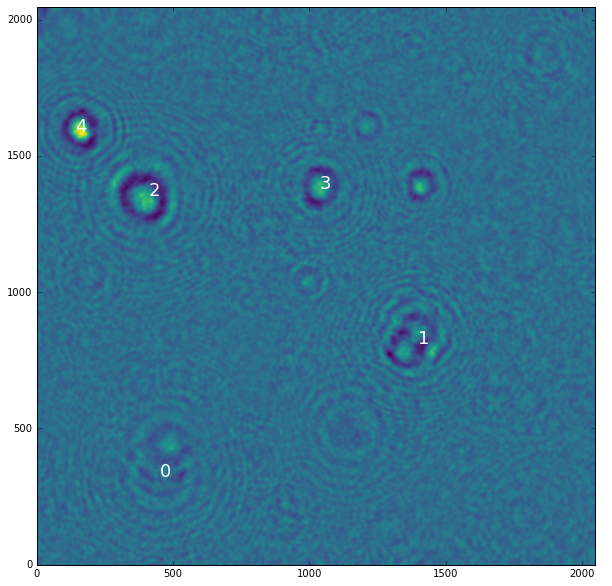

In [49]:
regions = regionprops(label_image, smooth_power)
centroids = [region.weighted_centroid for region in regions]

def plot_centroids(array, centroids):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array, **kwargs)
    for i, centroid in enumerate(centroids):
        ax.text(centroid[1], centroid[0], '{0}'.format(i), fontdict=dict(color='w', size=18))
    plt.show()

plot_centroids(smooth_h105, centroids)

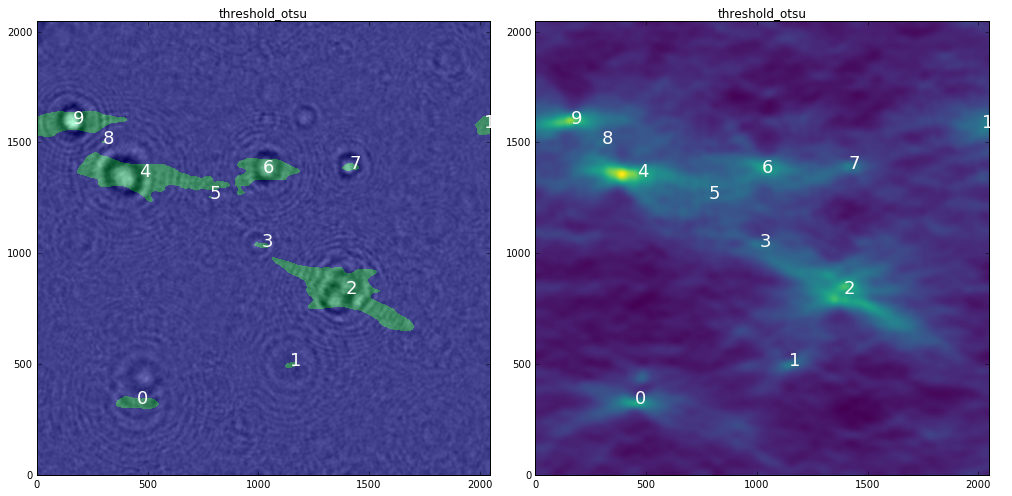

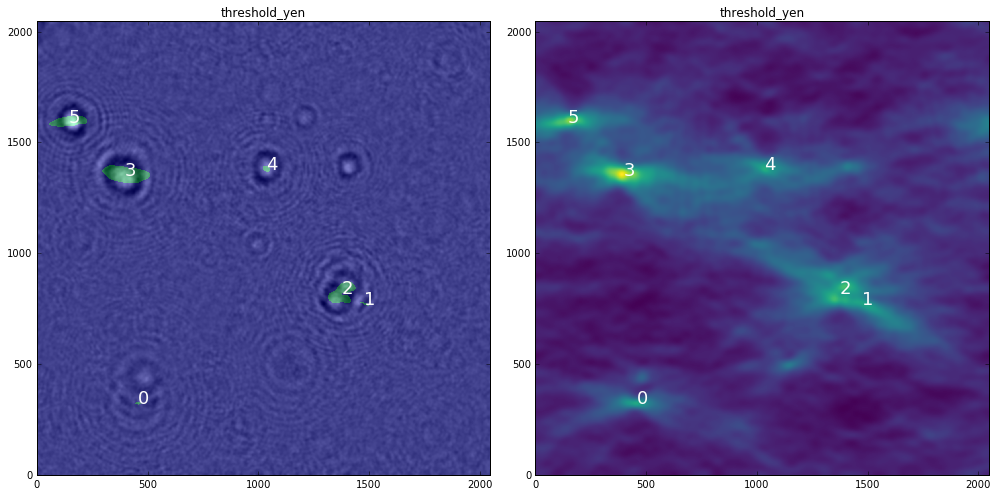

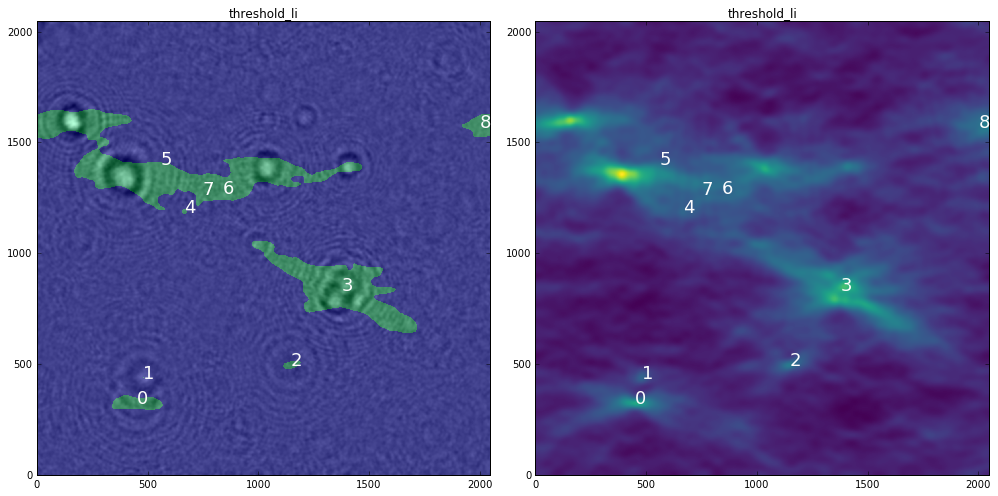

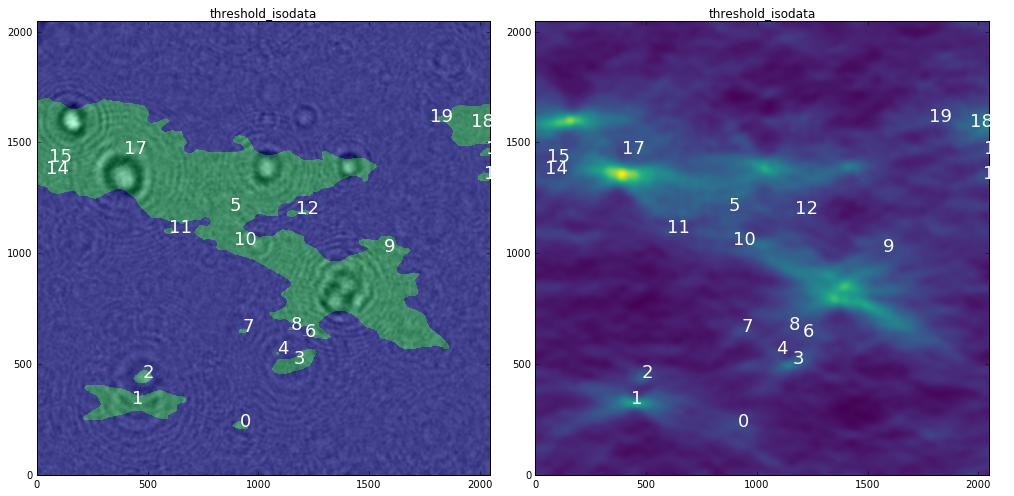

In [63]:
from skimage.filters import (threshold_otsu, threshold_yen, threshold_li, 
                             threshold_isodata, threshold_adaptive)

smooth_power = gaussian_filter(power, 15)
thresholds = [(threshold_method(smooth_power), threshold_method.__name__)
              for threshold_method in 
              [threshold_otsu, threshold_yen, threshold_li, threshold_isodata]]

for thresh, name in thresholds:
    masked = np.ones_like(smooth_power)
    masked[smooth_power <= thresh] = 0

    label_image = label(masked)

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(smooth_h105, interpolation='nearest', 
               origin='lower', cmap=plt.cm.binary_r)
    ax[0].imshow((label_image != 0).astype(int), alpha=0.3, interpolation='nearest', 
               origin='lower', cmap=plt.cm.winter)
    ax[0].set_title(name)

    ax[1].imshow(smooth_power, interpolation='nearest', 
               origin='lower', cmap=plt.cm.viridis)
#     ax[1].imshow((label_image != 0).astype(int), alpha=0.3, interpolation='nearest', 
#                origin='lower', cmap=plt.cm.winter)
    ax[1].set_title(name)
    
    regions = regionprops(label_image, smooth_power)
    centroids = [region.weighted_centroid for region in regions]
    
    for i, centroid in enumerate(centroids):
        ax[0].text(centroid[1], centroid[0], '{0}'.format(i), fontdict=dict(color='w', size=18))
        ax[1].text(centroid[1], centroid[0], '{0}'.format(i), fontdict=dict(color='w', size=18))
    fig.tight_layout()
    plt.show()